### Packages

In [1]:
cd '/h/ama/workspace/ama-at-vector/best-mix'

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import math
import pickle

from mixup import mixup_graph,mixup_process

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [4]:
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()

### Model, Data, Saliency

In [5]:
''' Model '''
resnet = models.resnet18(pretrained=True)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

resnet.eval()
criterion = nn.CrossEntropyLoss()

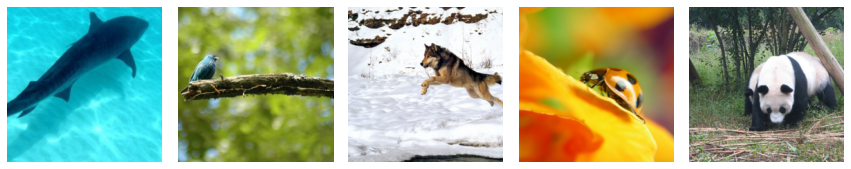

In [6]:
''' Data '''
img_exists = False 
sample_num = 5

if img_exists:
    # I used this codes to load data
    test_transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=mean, std=std)])

    sample_num = 5
    valdir = os.path.join('/Users/janghyun/Documents/Datasets/ImageNet', 'val')
    val_dset = datasets.ImageFolder(valdir, test_transform)
    val_loader = torch.utils.data.DataLoader(val_dset, batch_size=sample_num, shuffle=False, num_workers=2)

    ### Selected Examples
    input_sp = torch.stack([val_dset[3*50][0], val_dset[14*50][0], val_dset[269*50+2][0], val_dset[301*50+0][0], val_dset[388*50+2][0]], dim=0)
    targets = torch.tensor([val_dset[3*50][1], val_dset[14*50][1], val_dset[269*50+2][1], val_dset[301*50+0][1], val_dset[388*50+2][1]])

else:
    # I saved the processed images at figures folder
#     with open('figures/sample.data', 'rb') as file:
    with open('/h/ama/workspace/ama-at-vector/best-mix/figures/sample.data', 'rb') as file:
        input_sp, targets = pickle.load(file)
    
print_fig((input_sp * std_torch + mean_torch)[:sample_num])

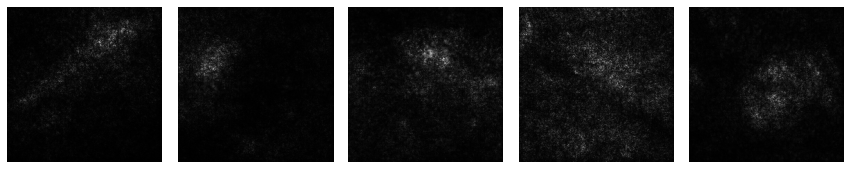

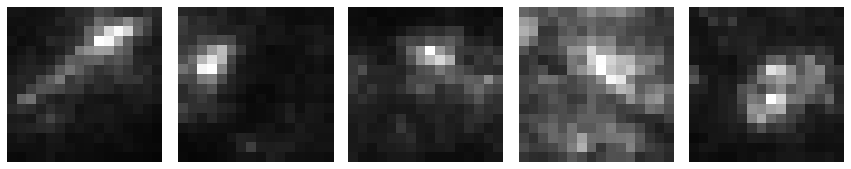

In [7]:
''' Saliency '''
input_var = input_sp[:sample_num].clone().detach().requires_grad_(True)
output = resnet(input_var)
loss = criterion(output, targets[:sample_num])
loss.backward()

unary = torch.sqrt(torch.mean(input_var.grad **2, dim=1))  
unary = unary / unary.view(sample_num, -1).max(1)[0].view(sample_num, 1, 1)
print_fig(unary)

unary16 = F.avg_pool2d(unary, 224//16)
unary16 = unary16 / unary16.view(sample_num, -1).max(1)[0].view(sample_num, 1, 1)
print_fig(unary16)

### Puzzle Mix

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix/mixup.py:295: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/torch/csrc/utils/tensor_new.cpp:201.)
  mask = torch.tensor(mask, dtype=torch.float32, device=device)


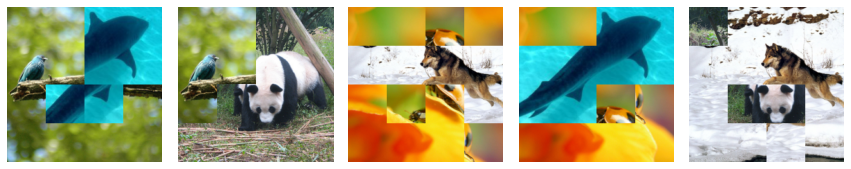

In [14]:
''' Transport '''
indices = [1,4,3,0,2]

n_labels = 2
block_num = 4

alpha = 0.4
beta = 0.2
gamma = 1.0
eta = 0.2

transport = True
t_eps=0.2
t_size=224//block_num

output = mixup_graph(input_sp.cuda(), unary.cuda(), indices=indices, n_labels=n_labels,
                     block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                     neigh_size=2, mean=mean_torch.cuda(), std=std_torch.cuda(), 
                     transport=transport, t_eps=t_eps, t_size=t_size, 
                     device='cuda')

print_fig(output[0].cpu() * std_torch + mean_torch)

puzzle_output = output

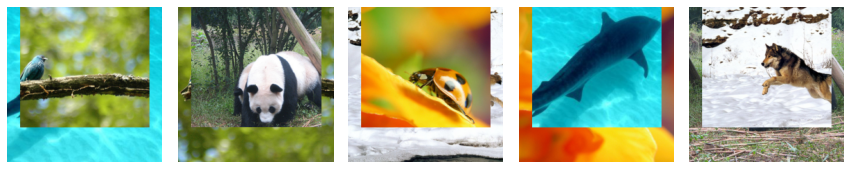

In [10]:
from mixup import mixup_box
indices = [1,4,3,0,2]

out, ratio = mixup_box(input_sp.cuda(), input_sp.cuda()[indices], alpha=0.3, device='cuda')
print_fig(out.cpu() * std_torch + mean_torch)

cutmix_output = out

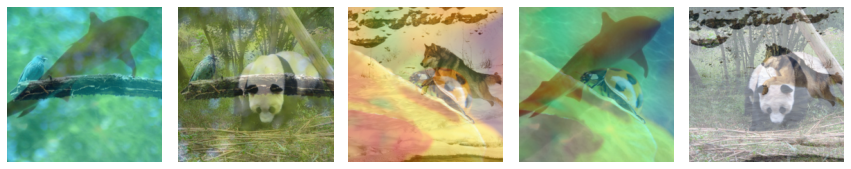

In [16]:
indices = [1,4,3,0,2]
lam=0.5
out = input_sp.cuda() * lam + input_sp.cuda()[indices] * (1 - lam)
print_fig(out.cpu() * std_torch + mean_torch)

vanilla_output = out

In [10]:
cd '/h/ama/workspace/ama-at-vector/Co-Mixup-master'

/scratch/ssd001/home/ama/workspace/ama-at-vector/Co-Mixup-master


In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import math
from match import get_onehot_matrix, mix_input
import pickle

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [12]:
def to_one_hot(inp, num_classes, device='cpu'):
    '''one-hot label'''
    y_onehot = torch.zeros((inp.size(0), num_classes), dtype=torch.float32, device=device)
    y_onehot.scatter_(1, inp.unsqueeze(1), 1)
    return y_onehot

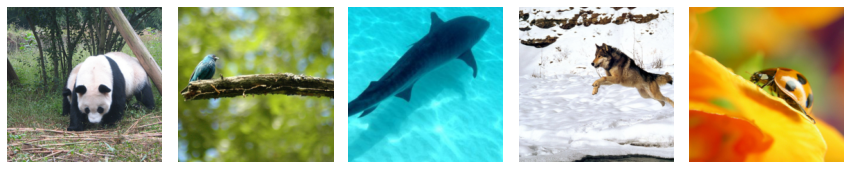

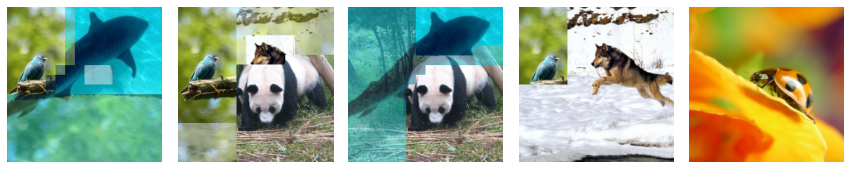

In [19]:
resnet = models.resnet18(pretrained=True)
resnet.eval()

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

test_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)])

n_input=5

with open('/h/ama/workspace/ama-at-vector/best-mix/figures/sample.data', 'rb') as file:
    input_sp, targets = pickle.load(file)


criterion = nn.CrossEntropyLoss()
bce_loss = nn.BCELoss()
softmax = nn.Softmax(dim=1)

'''Selected inputs for visualization'''
# indices = [(356, 2), (948, 5), (852, 2), (3, 1), (1, 19), (3,27), (11,9), (11,20), (11,45), (14,29), (162, 7), (167,3), (167,41),
#           (215, 6),  (215, 11), (215, 23), (215, 24), (215, 40), (240, 34), (240, 49), (269,21), (269, 37), (301,0), (388,19)]
# inputs = torch.stack([val_dset[idx[0]*50 + idx[1]][0] for idx in indices], dim=0)
# targets = torch.tensor([idx[0] for idx in indices])

# input_sp=input_sp[]
index = [4,1,0,2,3] 
input_sp =input_sp[index]
# input_sp = torch.flip(input_sp,dims=[0])
target_onehot = to_one_hot(targets, num_classes=1000)
target_onehot = target_onehot[index]
# target_onehot = torch.flip(target_onehot,dims=[0])
           
'''Calculate saliency'''
input_var = input_sp.clone().detach().requires_grad_(True)
output = resnet(input_var)
# loss = criterion(output, targets)
loss = bce_loss(softmax(output), target_onehot)
loss.backward()

unary = torch.sqrt(torch.mean(input_var.grad **2, dim=1))  
unary = unary / unary.view(n_input, -1).max(1)[0].view(n_input, 1, 1)

unary16 = F.avg_pool2d(unary, 224//16)
unary16 = unary16 / unary16.view(n_input, -1).max(1)[0].view(n_input, 1, 1)
    
print_width = 5
for i in range(n_input // print_width):
    print_fig((input_sp * std_torch + mean_torch)[print_width*i: print_width*(i+1)])
    
beta = 2.0
gamma = 1.0
thres = 0.86
n_output=5
cost_matrix = - unary16 / unary16.view(n_input, -1).sum(-1).view(n_input, 1, 1)
for k in [0,]:
    np.random.seed(k)
    A = torch.eye((n_input))
    mask_onehot = get_onehot_matrix(cost_matrix, A, n_output, beta=beta, gamma=gamma, eta=0.0, thres=thres, device='cpu')    
    outputs, target_reweighted = mix_input(mask_onehot, input_sp, target_onehot)
    for i in range(n_input // print_width):
        print_fig((outputs * std_torch + mean_torch)[print_width*i: print_width*(i+1)])

    print("="*100)
    
co_output = outputs

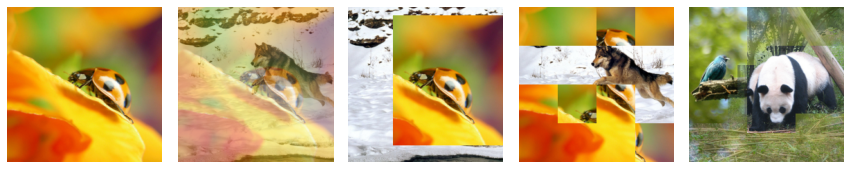

In [42]:
compare_output = torch.zeros_like(input_sp)
compare_output[0] = input_sp[1]
compare_output[1] = vanilla_output[2]
compare_output[2] = cutmix_output[2]
compare_output[3] = puzzle_output[0][2]
compare_output[4] = co_output[2]

# print_fig(input_sp.cpu() * std_torch + mean_torch)
# print_fig(puzzle_output[0].cpu() * std_torch + mean_torch)
# print_fig(co_output.cpu() * std_torch + mean_torch)
# print_fig(cutmix_output.cpu() * std_torch + mean_torch)
# print_fig(vanilla_output.cpu() * std_torch + mean_torch)
print_fig(compare_output.cpu() * std_torch + mean_torch)
